<a href="https://colab.research.google.com/github/AJITHKANNAN/Deep-Learning-Tutorials/blob/main/Spam_Classification_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT tutorial: Classify spam vs no spam emails


In [1]:
pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
# Import the dataset (Dataset is taken from kaggle)
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [6]:
df['Category'].value_counts()


ham     4825
spam     747
Name: Category, dtype: int64

In [7]:
747/4825


0.15481865284974095

# 15% spam emails, 85% ham emails: This indicates class imbalance

#

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape


(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
# Downsampling (note that: you might lose many data)
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

#  concat spam and down sampled HAM

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()


ham     747
spam    747
Name: Category, dtype: int64

# Create a new column called 'Spam' and  convert Categories to 0 and 1  (Ham and Spam)

In [13]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
5476,ham,Yes princess! I want to please you every night...,0
3872,ham,Yeah my usual guy's out of town but there're d...,0
3087,ham,I wish that I was with you. Holding you tightl...,0
5366,spam,A £400 XMAS REWARD IS WAITING FOR YOU! Our com...,1
789,spam,"5 Free Top Polyphonic Tones call 087018728737,...",1


# Split it into training and test data set


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( df_balanced['Message'], df_balanced['spam'], stratify= df_balanced['spam'])
# \ stratify to make sure equal distribution of sample

In [15]:
X_train.head(4)


2485    Only if you promise your getting out as SOON a...
1300    Great to hear you are settling well. So what's...
2003    TheMob>Yo yo yo-Here comes a new selection of ...
3612                     No. I.ll meet you in the library
Name: Message, dtype: object

# Now lets import BERT model and get embeding vectors for few sample statements


In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
best_preprocess_model = hub.KerasLayer(bert_preprocess)


text = ["nice movie indeed"]

text_preprocessed = best_preprocess_model(text)


In [18]:
text_preprocessed

{'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[ 101, 3835, 3185, 5262,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1,

# Explanation

# shape=(1, 128)

Is because we have paseed only 1 sentence and 128 is the maximum length_of_indexer

#  array([[ 101, 3835, 3185, 5262,  102,   remaining upto 128 are 0 because of padding

We passed 3 words in a sentence but returned 5 tokens in the Masking

because BERT has special component called 'CLS' and 'SEP' which has the fixed ID as 101, 102 an will get automatically added CLS in the beginning and SEP at the end of the words passed

In [19]:
text_preprocessed.keys()

dict_keys(['input_word_ids', 'input_type_ids', 'input_mask'])

In [20]:
text_preprocessed['input_word_ids']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[ 101, 3835, 3185, 5262,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)>

In [21]:
text_preprocessed['input_type_ids']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [22]:
text_preprocessed['input_mask']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

# BERT Model

In [23]:
model = hub.KerasLayer(bert_encoder)

# supply preprocessed text

results = model(text_preprocessed)

In [24]:
results.keys()

dict_keys(['sequence_output', 'encoder_outputs', 'default', 'pooled_output'])

In [25]:
results['pooled_output']

#  This represents each input sequence as a whole. The shape is (batch_size, H).

#  shape=(1, 768)

# We have 1 sentence passed and the maximum embeddings(unique numbers for similar words ) is 768
# which accurately represnts the given sentence

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-7.91773856e-01, -2.14119092e-01,  4.97694999e-01,
         4.73431796e-01, -1.80652291e-01, -8.33084732e-02,
         8.14969540e-01,  1.44600809e-01,  2.04916120e-01,
        -9.99240041e-01,  1.36825517e-01,  8.30048323e-03,
         9.51741576e-01, -3.63364667e-01,  8.72413635e-01,
        -4.07976568e-01, -3.00641861e-02, -4.13878918e-01,
         2.43135571e-01, -6.50724053e-01,  4.46718186e-01,
         7.56984770e-01,  5.95490694e-01,  1.58233672e-01,
         2.40729541e-01,  1.85461193e-01, -5.00944316e-01,
         8.72952282e-01,  9.05975044e-01,  5.36843598e-01,
        -5.62124133e-01,  9.55323577e-02, -9.55684125e-01,
        -8.73648748e-02,  5.06407499e-01, -9.52129483e-01,
         6.01504706e-02, -6.85674369e-01,  6.50394559e-02,
         2.19803806e-02, -8.37848842e-01,  1.31664664e-01,
         9.86527085e-01, -3.81034732e-01, -1.99163452e-01,
        -2.51670927e-01, -9.98164058e-01,  1.07079916e-01,
      

In [26]:
results['sequence_output']

#  sequnence Outputs
# : This represents each input token in the context. The shape is (batch_size, seq_length, H).
# shape=(1, 128, 768),

# each token in the sequnece have 768 hidden embeddings to give accrate results

<tf.Tensor: shape=(1, 128, 768), dtype=float32, numpy=
array([[[ 0.07292062,  0.0856778 ,  0.1447685 , ..., -0.09677092,
          0.08722138,  0.07711118],
        [ 0.17839387, -0.19006082,  0.5034943 , ..., -0.05869817,
          0.32717144, -0.15578564],
        [ 0.18701456, -0.43388784, -0.48875132, ..., -0.15502763,
          0.00145165, -0.2447095 ],
        ...,
        [ 0.12083055,  0.12884246,  0.46453553, ...,  0.07375517,
          0.17441934,  0.16522156],
        [ 0.07967898, -0.01190664,  0.50225395, ...,  0.13777721,
          0.21002224,  0.00624594],
        [-0.07212677, -0.28303456,  0.590334  , ...,  0.47551885,
          0.16668522, -0.08920377]]], dtype=float32)>

In [27]:
results['encoder_outputs']

# encoder_outputs
# : This represents the outputs of each encoder layer. The shape is (batch_size, seq_length, H).


[<tf.Tensor: shape=(1, 128, 768), dtype=float32, numpy=
 array([[[ 0.12901421,  0.00644755, -0.03614964, ...,  0.04999626,
           0.06149197, -0.02657553],
         [ 1.1753379 ,  1.2140783 ,  1.1569979 , ...,  0.11634398,
          -0.35855332, -0.4049018 ],
         [ 0.0385902 ,  0.5386997 , -0.21089807, ...,  0.21858224,
           0.72601664, -1.1158607 ],
         ...,
         [-0.07587017, -0.25421888,  0.70755106, ...,  0.5054204 ,
          -0.1887868 ,  0.15028353],
         [-0.16066614, -0.2808969 ,  0.57597053, ...,  0.5275854 ,
          -0.11141373,  0.02887545],
         [-0.04428158, -0.20279579,  0.5909355 , ...,  0.8133835 ,
          -0.390758  , -0.02601755]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 128, 768), dtype=float32, numpy=
 array([[[ 0.01418123, -0.22088237, -0.1502817 , ...,  0.11415627,
           0.12618098,  0.04843384],
         [ 1.20339   ,  1.3469863 ,  1.706453  , ...,  0.30610606,
          -0.50742555, -0.5514745 ],
         [ 0.4216905 , 

In [28]:
results['default']

# default
# : This is the default output of the BERT model. It is the pooled_output.



<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-7.91773856e-01, -2.14119092e-01,  4.97694999e-01,
         4.73431796e-01, -1.80652291e-01, -8.33084732e-02,
         8.14969540e-01,  1.44600809e-01,  2.04916120e-01,
        -9.99240041e-01,  1.36825517e-01,  8.30048323e-03,
         9.51741576e-01, -3.63364667e-01,  8.72413635e-01,
        -4.07976568e-01, -3.00641861e-02, -4.13878918e-01,
         2.43135571e-01, -6.50724053e-01,  4.46718186e-01,
         7.56984770e-01,  5.95490694e-01,  1.58233672e-01,
         2.40729541e-01,  1.85461193e-01, -5.00944316e-01,
         8.72952282e-01,  9.05975044e-01,  5.36843598e-01,
        -5.62124133e-01,  9.55323577e-02, -9.55684125e-01,
        -8.73648748e-02,  5.06407499e-01, -9.52129483e-01,
         6.01504706e-02, -6.85674369e-01,  6.50394559e-02,
         2.19803806e-02, -8.37848842e-01,  1.31664664e-01,
         9.86527085e-01, -3.81034732e-01, -1.99163452e-01,
        -2.51670927e-01, -9.98164058e-01,  1.07079916e-01,
      

In [29]:
def get_sentence_embeding(sentences):

    preprocessed_text = bert_preprocess(sentences)

    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132727 , -0.8884572 , ..., -0.7474886 ,
        -0.75314724,  0.91964495],
       [-0.8720834 , -0.50543964, -0.94446665, ..., -0.8584749 ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

# Get embeding vectors for few sample words. Compare them using cosine similarity


In [30]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]],[e[1]])

array([[0.9911087]], dtype=float32)

# Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [32]:
cosine_similarity([e[0]],[e[3]])


array([[0.8470381]], dtype=float32)

# Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes



In [33]:
cosine_similarity([e[3]],[e[4]])


array([[0.9872034]], dtype=float32)

# Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above



# Build Model

There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [34]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [35]:
# https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py



In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [37]:
len(X_train)


1120

In [38]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

# Train the model


In [47]:
model.fit(X_train, y_train, epochs= 3)

Epoch 1/3
35/35 [==============================] - 12s 351ms/step - loss: 0.4925 - accuracy: 0.8214 - precision: 0.7922 - recall: 0.8714
Epoch 2/3
35/35 [==============================] - 12s 354ms/step - loss: 0.4340 - accuracy: 0.8527 - precision: 0.8496 - recall: 0.8571
Epoch 3/3
35/35 [==============================] - 13s 359ms/step - loss: 0.3867 - accuracy: 0.8741 - precision: 0.8463 - recall: 0.9143


In [48]:
model.evaluate(X_test, y_test)


12/12 [==============================] - 4s 333ms/step - loss: 0.3390 - accuracy: 0.9225 - precision: 0.9202 - recall: 0.9251


[0.3390490412712097,
 0.9224599003791809,
 0.9202127456665039,
 0.9251337051391602]

In [49]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()



12/12 [==============================] - 4s 366ms/step


In [51]:
y_predicted[:5]

array([0.73930234, 0.7735341 , 0.78531075, 0.34491473, 0.8328545 ],
      dtype=float32)

In [54]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [55]:
from collections import Counter

count = Counter(y_predicted)

print(count)

Counter({1: 188, 0: 186})


In [56]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[172,  15],
       [ 14, 173]])

Text(50.722222222222214, 0.5, 'Truth')

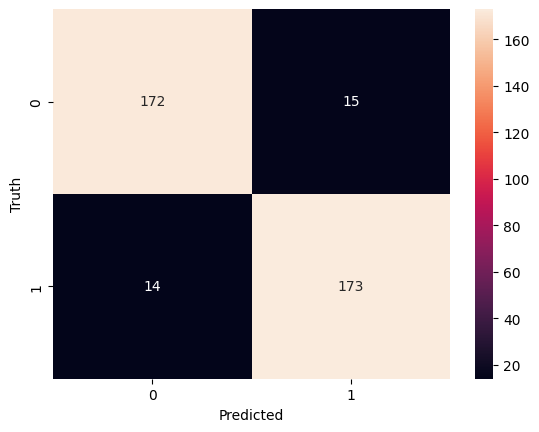

In [57]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [58]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       187
           1       0.92      0.93      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



# Inference


In [59]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 0s 46ms/step


array([[0.64517045],
       [0.657811  ],
       [0.6547339 ],
       [0.29964933],
       [0.21616206]], dtype=float32)